In [35]:
import os 
import sys
from datetime import date, datetime
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd
import json
from collections import defaultdict, OrderedDict

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

sys.path.append('../')
import numpy.random as random
from src.datasets.data import PAMAP2Reader
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss

# from src.running import train_step1, eval_step1
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

In [36]:
from src.utils.analysis import action_evaluator

In [37]:
from sklearn.manifold import TSNE
from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [38]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "RelativeGlobalAttention",
    
    "sem-space": 'attr',
    # model training configs
    "model_params":{
        "linear_filters":[512,1024,1024,256],
        "input_feat":36,
        "dropout":0.1,
    },
    "include_attribute_loss": True, 
    "n_actions": 18,
    "folding": True,
    "lr": 0.001,
    "ae_lr": 0.0001,
    "imu_lr": 0.0004,
    "ae_alpha": 0.9,
    "imu_alpha": 0.0001,
    "n_epochs": 15,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 512, 
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 64,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.2,
    "unseen_split": 0.8
}

In [39]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [40]:
dataReader = PAMAP2Reader('data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


---
Model Building

In [41]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.fcLayer1(F.relu(out))
        # out = self.fcLayer2(out)
        return out

In [42]:
# test model 
sample_input = torch.randn((32, 120, 42))
model = IMUEncoder(in_ft=42, d_model=128, num_heads=2, ft_size=400, n_classes=2, max_len=120, dropout=0.1)
sample_output = model(sample_input)
sample_output.shape

torch.Size([32, 400])

---

In [43]:

class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.concat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32, device='cpu'):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.device = device

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)
              
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

    def forward(self,encoder_hidden):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((self.batch_size,4,self.hidden_size))
            # print(hidden.shape)
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
        else:
            hidden = encoder_hidden.view((self.batch_size,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
        
        dummy_input = torch.rand((self.batch_size,self.seq_len,self.hidden_size), requires_grad=True)
        dummy_input = dummy_input.to(self.device)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        return x

class SkeletonAE(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True, batch_size=32, device='cpu'):
        super(SkeletonAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32, device=device)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  
        

In [44]:
ae_model = SkeletonAE(seq_len=50, input_size=36, hidden_size=512, linear_filters=[128,256,512], embedding_size=512, num_layers=1,bidirectional=True,batch_size=32)
prep_dir = 'model_saves/bidiretional_lstm/epoch100_emb512.pt'
ae_model.load_state_dict(torch.load(prep_dir)["model_state_dict"])

<All keys matched successfully>

In [45]:
prep_dir = 'model_saves/bidiretional_lstm/epoch100_emb512.pt'
torch.load(prep_dir)['model_config']

{'seq_len': 50,
 'input_size': 36,
 'hidden_size': 512,
 'linear_filters': [128, 256, 512],
 'embedding_size': 512,
 'num_layers': 1,
 'bidirectional': True,
 'batch_size': 32,
 'dev': device(type='cuda')}

---

In [46]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
dataReader.data.shape

(124,)

In [48]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [49]:
skeleton_data = np.load('data/I3D/video_feat/PAMAP2_K10_V1/feat_dict_400.npz')
skeleton_classes, skeleton_mov = skeleton_data['activity'], skeleton_data['features']

un_skeleton = []
un_mov = []
for __cls in np.unique(skeleton_classes):
    un_skeleton.append(__cls)
    un_mov.append(skeleton_mov[skeleton_classes==__cls].mean(axis=0))

skeleton_classes = np.asarray(un_skeleton)
skeleton_mov = np.asarray(un_mov)

print(skeleton_mov.shape)
print(np.unique(skeleton_classes, return_counts=True))
print(dataReader.label_map)
print(np.unique(skeleton_classes))

(18, 400)
(array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playing soccer',
       'rope jumping', 'running', 'sitting', 'standing',
       'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17'), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64))
[(1, 'lying'), (2, 'sitting'), (3, 'standing'), (4, 'walking'), (5, 'running'), (6, 'cycling'), (7, 'Nordic walking'), (9, 'watching TV'), (10, 'computer work'), (11, 'car driving'), (12, 'ascending stairs'), (13, 'descending stairs'), (16, 'vacuum cleaning'), (17, 'ironing'), (18, 'folding laundry'), (19, 'house cleaning'), (20, 'playing soccer'), (24, 'rope jumping')]
['Nordic walking' 'ascending stairs' 'car driving' 'computer work'
 'cycling' 'descending stairs' 'folding laundry' 'house cleaning'
 'ironing' 'lying' 'playing soccer' 'rope jumping' 'running' 'sitting'
 'standing' '

In [50]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(skeleton_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

action_dict = OrderedDict(list(action_dict.items()))

In [51]:
video_feat = skeleton_mov

In [52]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [53]:
# selecting_video_prototypes(video_feat,video_classes,vid_cls_name).shape

In [54]:
dataReader.label_map

[(1, 'lying'),
 (2, 'sitting'),
 (3, 'standing'),
 (4, 'walking'),
 (5, 'running'),
 (6, 'cycling'),
 (7, 'Nordic walking'),
 (9, 'watching TV'),
 (10, 'computer work'),
 (11, 'car driving'),
 (12, 'ascending stairs'),
 (13, 'descending stairs'),
 (16, 'vacuum cleaning'),
 (17, 'ironing'),
 (18, 'folding laundry'),
 (19, 'house cleaning'),
 (20, 'playing soccer'),
 (24, 'rope jumping')]

In [55]:
action_dict

OrderedDict([(6, [0]),
             (10, [1]),
             (9, [2]),
             (8, [3]),
             (5, [4]),
             (11, [5]),
             (14, [6]),
             (15, [7]),
             (13, [8]),
             (0, [9]),
             (16, [10]),
             (17, [11]),
             (4, [12]),
             (1, [13]),
             (2, [14]),
             (12, [15]),
             (3, [16]),
             (7, [17])])

In [56]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)

In [57]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [58]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)
sample_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=data_dict['seen_classes'], seq_len=100)
sample_dl = DataLoader(sample_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)
for d in sample_dl:
    print(d[0].shape, torch.isnan(d[0]).sum().item())
    break


torch.Size([32, 105, 27]) 0


In [59]:
torch.isnan(d[0]).sum()

tensor(0)

---

In [60]:
class SkeletonDataset(Dataset):
    def __init__(self, movements, actions, action_dict, seq_len=60):
        super(SkeletonDataset, self).__init__()
        self.movements = torch.from_numpy(movements[:, :seq_len, ...])
        self.actions = actions
        self.action_dict = deepcopy(dict(action_dict))
        self.actionsIDs = list(self.action_dict.keys())  

    def __getitem__(self, idx):
        x1 = self.movements[idx, ...]
        action = self.actions[idx]
        # partial_idx = random.sample(self.action_dict[action], k=1)[0]
        # x2 = self.movements[partial_idx, ...]
        label = self.actionsIDs.index(action)
        # return np.transpose(x1, (1,0,2)), np.transpose(x2, (1,0,2)), label
        return x1, label

    def __len__(self):
        return self.movements.shape[0]

    def getShape(self):
        return self.movements[0, ...].shape

    def get_actions(self, label):
        return self.movements[self.action_dict[label], ...]

In [61]:
sample_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=50)
sample_dl = DataLoader(sample_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
for b in sample_dl:
    bx1, by = b 
    # bx = torch.transpose(bx1, 1, 0)
    bs, seq_len, ft_in = bx1.shape
    print(bx1.shape)
    break 

---

In [62]:
def get_class_ft(data, model, device, bs=32):
    ns, _, _ = data.shape 
    padded_mat = F.pad(input=data, pad=(0,0,0,0,0,bs-ns), mode='constant', value=0)
    _, vector_out = model(padded_mat.float().to(device)) # batch second mode
    action_feat_mat = vector_out[:ns, :].cpu().detach().numpy()
    return action_feat_mat

In [63]:
def loss_cross_entropy(
        y_pred:torch.Tensor,
        c:torch.Tensor,
        selected_features,
        loss_fn=nn.CrossEntropyLoss(reduction="sum")
):
    num_classes = selected_features.size()[0]
    #print(selected_features)
    cosine_sim_comb = []
    for entry in y_pred.unbind():
        #print(entry.repeat(num_classes,1),selected_features.size())
        cosine_sim = F.softmax(F.cosine_similarity(entry.repeat(num_classes,1),selected_features),dim=-1)
        cosine_sim_comb.append(cosine_sim)

    cosine_sim_comb = torch.stack(cosine_sim_comb)
    loss = loss_fn(cosine_sim_comb,c)
    #print(loss)
    return loss

def predict_class(y_pred, selected_features):
    num_classes = selected_features.size()[0]

    cosine_sim_comb = []
    for entry in y_pred.unbind():
        cosine_sim = torch.argmax(F.softmax(F.cosine_similarity(entry.repeat(num_classes,1),selected_features),dim=-1))
        cosine_sim_comb.append(cosine_sim)

    pred = torch.stack(cosine_sim_comb)
    return pred

In [64]:
def loss_reconstruction_calc(y_pred:torch.Tensor,y_feat:torch.Tensor,loss_fn=nn.L1Loss(reduction="sum")):
    bat_size,feature_size = y_pred.size()
    loss = loss_fn(y_pred,y_feat)*(1/feature_size)
    #print(loss)
    return loss

In [65]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

def ae_train_step1(model, dataloader, optimizer, loss_module, device, batch_size, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    model.to(device)

    const_loss = 0 
    recons_loss = 0
    epoch_loss = 0 

    with tqdm(dataloader, unit='batch', desc=phase) as tepoch:
        for batch in tepoch:
            xa, labels = batch 
            # post-process 
            # xa = torch.vstack([x1, x2])  # batch first mode
            # device offload 
            xa = xa.float().to(device)
            labels = labels.float()

            # set optimizer grad to zero 
            optimizer.zero_grad()
            # get model prediction 
            with torch.set_grad_enabled(phase=='train'):
                skel_output, ft_output = model(xa)

            # reconstruct the output 
            # f1, f2 = torch.split(ft_output, [batch_size//2, batch_size//2], dim=0)
            # cons_output = torch.stack([f1.squeeze(1), f2.squeeze(1)], dim=1)
            # calc. contrastive loss 
            con_loss = loss_module['contrast'](ft_output, labels)()
            # calc. reconstruction loss 
            l2_loss = loss_module['recons'](xa, skel_output)
            # calc. total loss
            # total_loss = con_loss #
            total_loss = loss_alpha*con_loss + (1-loss_alpha)*l2_loss

            if phase == 'train':
                total_loss.backward()
                optimizer.step()

            metrics = {'contrastive loss ': con_loss.item(), 'reconstruction loss': l2_loss.item()}
            with torch.no_grad():
                    const_loss += con_loss.item()    
                    recons_loss += l2_loss.item()
                    epoch_loss += total_loss.item()
            tepoch.set_postfix(metrics)

    m = len(dataloader)
    epoch_metrics = {'total_loss': epoch_loss/m, 'contrastive_loss': const_loss/m, 'reconstruction_loss':recons_loss/m}
    return epoch_metrics

In [66]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss = loss_cross_entropy(feat_output, targets.squeeze(), random_selected_feat, loss_fn=loss_module['class'])
                feat_loss = loss_reconstruction_calc(feat_output, target_feat, loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            pred_action = predict_class(feat_output, random_selected_feat)

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report)
    return metrics_dict

In [67]:
def plot_tnse(X, y, Id2Label):
    tnse = TSNE(n_components=2, init='random', learning_rate='auto', perplexity=15, n_iter=1000)
    cmp_data = tnse.fit_transform(X)

    cmp_df = pd.DataFrame(data=cmp_data, columns=['x', 'y'])
    cmp_df['label'] = y
    cmp_df['action'] = cmp_df['label'].map(Id2Label)

    fig = px.scatter(cmp_df, x='x', y='y', color='action', width=800, height=800, title='t-SNE')
    fig.show()
    return fig

def get_action_vector(ae, skel_dt, device, class_ids, class_names, batch_size=32):
    # generate unseen action_semantic from unseen skeleton seq. 
    label_dict = {c:i for i,c in enumerate(class_ids)}
    all_actions = []
    all_labels = []
    for c in class_ids:
        action_mat = skel_dt.get_actions(c)
        ns, _, _ = action_mat.shape 
        class_labels = [label_dict[c] for _ in range(ns)]
        padded_mat = F.pad(input=action_mat, pad=(0,0,0,0,0,batch_size-ns), mode='constant', value=0)
        _, vector_out = ae(padded_mat.float().to(device)) # batch second mode
        action_feat_mat = vector_out[:ns, :].cpu().detach().numpy() # batch second mode

        all_actions.append(action_feat_mat)
        all_labels.append(class_labels)

    all_actions = np.concatenate(all_actions)
    all_labels = np.concatenate(all_labels)
    Id2Label = {i:l for i,l in enumerate(class_names)}
    return all_actions, all_labels, Id2Label

print("Initiate Skeleton dataset ... ")
# prep_dir = './tmp/epoch50_randsample_input_mseloss.pt'
prep_dir = '../data/Pre-trained Skeleton models/PAMAP2/epoch100_emb128.pt'

# build Skeleton dataset 
skel_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=config['seq_len'])
skel_dl = DataLoader(skel_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
skel_n, skel_fts = skel_dt.getShape()

# build AE Model 
# ae_model = BiLSTMEncDecModel(input_size=skel_fts, seq_len=skel_n, hidden_size=config['feat_size'], batch_size=config['batch_size'], ae_type='recursive', device=device)
ae_config = {
    'seq_len':skel_n,
    'input_size':skel_fts, 
    'hidden_size':512, 
    'linear_filters':[128,256,512], 
    'embedding_size':config['feat_size'], 
    'num_layers':1, 
    'bidirectional':True, 
    'batch_size':config['batch_size']
}
ae_model = SkeletonAE(device=device, **ae_config)
# ae_model = BiLSTMEncDecModel(seq_len=50, input_size=36, hidden_size=512, linear_filters=[128,256,512], embedding_size=256, num_layers=1,bidirectional=True,batch_size=32, device=device)
ae_model.load_state_dict(torch.load(prep_dir)['model_state_dict'])
ae_model.to(device)

# define AE run parameters 
ae_optim = Adam(ae_model.parameters(), lr=config['ae_lr'])
ae_loss_module = {'contrast': SoftNearestNeighbours, 'recons': nn.MSELoss()}

ae_train_data = []
for epoch in tqdm(range(150), desc='Training Epoch', leave=False):
    # train AE model 
    ae_train_metrics = ae_train_step1(ae_model, skel_dl, ae_optim, ae_loss_module, device, config['batch_size'], phase='train', loss_alpha=config['ae_alpha'])
    ae_train_metrics['epoch'] = epoch
    ae_train_data.append(ae_train_metrics)

ae_train_df = pd.DataFrame().from_records(ae_train_data)

# plot train metrics 
fig, ax = plt.subplots()

ax.plot(ae_train_df['total_loss'], color = 'green', label = 'total_loss')
ax.plot(ae_train_df['contrastive_loss'], color = 'red', label = 'contrastive_loss')
ax.plot(ae_train_df['reconstruction_loss'], color = 'blue', label = 'reconstruction_loss')
ax.legend(loc = 'upper right')
plt.show()

# save transfer learned AE model weights 
t = datetime.now().strftime("%Y_%m_%d_%H_%M")
ae_trans_dir = f'../tmp/pamap2/ae_model_transfer_{t}.pt'
torch.save({
    'model_state_dict': ae_model.state_dict(),
    'config': ae_config
}, ae_trans_dir)

val_actions, val_labels, val_lm = get_action_vector(ae_model, skel_dt, device, class_ids=range(18), class_names=dataReader.idToLabel)
tsne_skel_plot = plot_tnse(val_actions, val_labels, val_lm)

---

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
Initiate IMU datasets ...


train: 100%|██████████| 255/255 [02:55<00:00,  1.46batch/s, loss=42.8, accuracy=0]

seen: 100%|██████████| 63/63 [00:28<00:00,  2.22batch/s, loss=38.1]


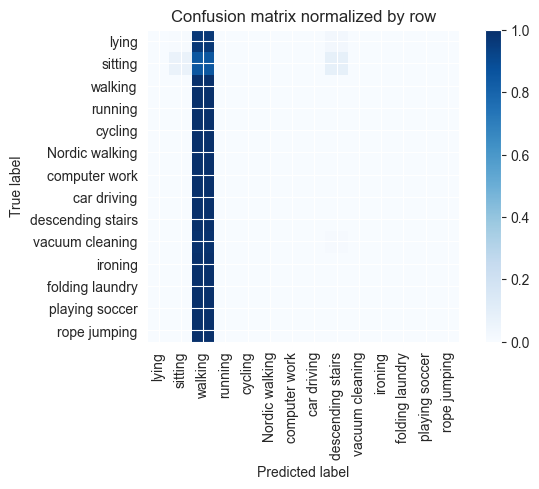

Training Epoch:   7%|▋         | 1/15 [03:24<47:46, 204.78s/it]

Overall accuracy: 0.112




train: 100%|██████████| 255/255 [08:41<00:00,  2.04s/batch, loss=29.3, accuracy=0.375]

seen: 100%|██████████| 63/63 [01:01<00:00,  1.02batch/s, loss=29.6]


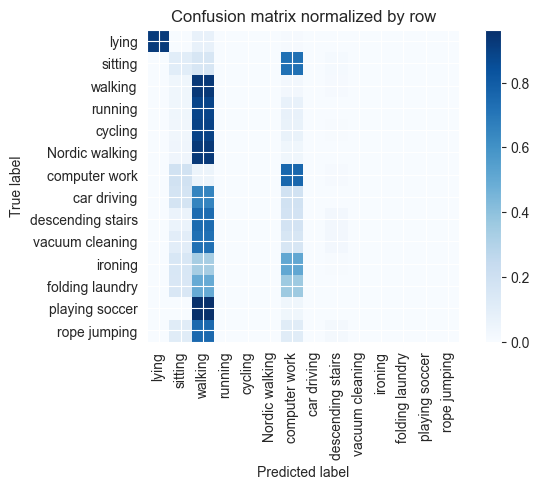

Training Epoch:  13%|█▎        | 2/15 [13:08<1:32:41, 427.79s/it]

Overall accuracy: 0.314




train: 100%|██████████| 255/255 [09:56<00:00,  2.34s/batch, loss=31.1, accuracy=0.25]

seen: 100%|██████████| 63/63 [01:01<00:00,  1.02batch/s, loss=23.5]


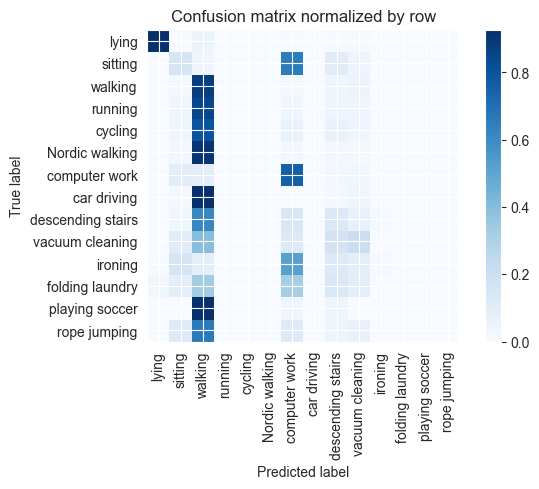

Training Epoch:  20%|██        | 3/15 [24:07<1:46:41, 533.43s/it]

Overall accuracy: 0.334




train: 100%|██████████| 255/255 [10:56<00:00,  2.57s/batch, loss=28.4, accuracy=0.344]

seen: 100%|██████████| 63/63 [01:01<00:00,  1.02batch/s, loss=30.7]


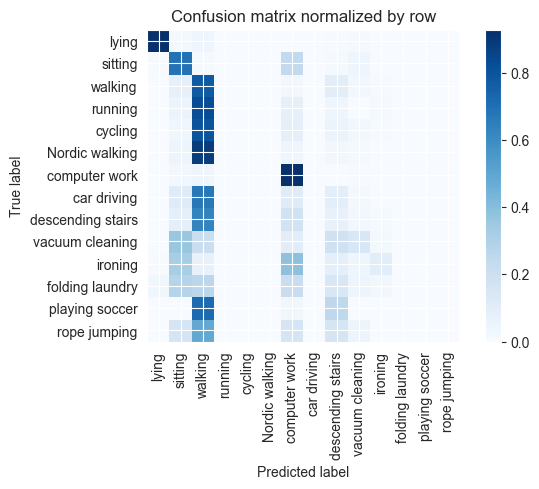

Training Epoch:  27%|██▋       | 4/15 [36:06<1:51:11, 606.54s/it]

Overall accuracy: 0.397




train: 100%|██████████| 255/255 [11:28<00:00,  2.70s/batch, loss=34.9, accuracy=0.312]

seen: 100%|██████████| 63/63 [01:02<00:00,  1.02batch/s, loss=25.2]


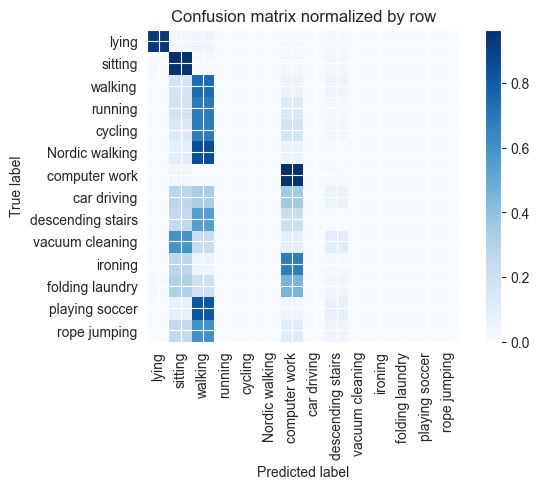

Training Epoch:  33%|███▎      | 5/15 [48:37<1:49:47, 658.72s/it]

Overall accuracy: 0.392




train: 100%|██████████| 255/255 [12:06<00:00,  2.85s/batch, loss=20.6, accuracy=0.562]

seen: 100%|██████████| 63/63 [01:01<00:00,  1.02batch/s, loss=23.2]


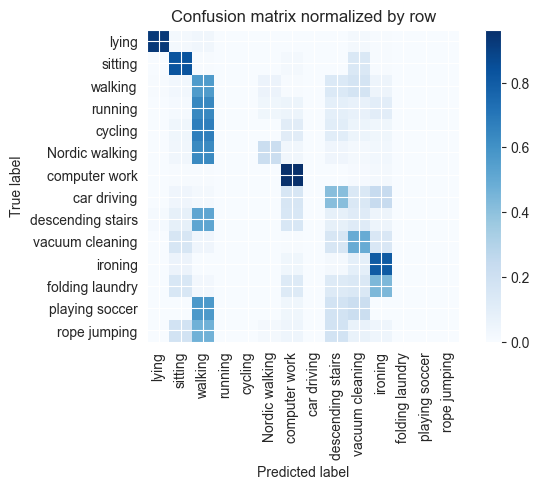

Training Epoch:  40%|████      | 6/15 [1:01:46<1:45:25, 702.84s/it]

Overall accuracy: 0.520




train: 100%|██████████| 255/255 [11:58<00:00,  2.82s/batch, loss=27.6, accuracy=0.438]

seen: 100%|██████████| 63/63 [01:02<00:00,  1.01batch/s, loss=29.7]


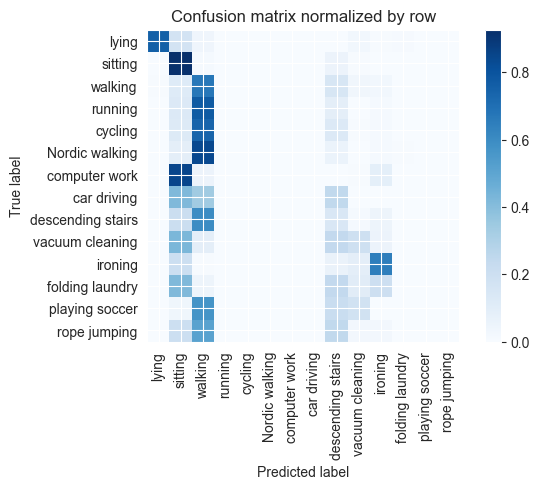

Training Epoch:  47%|████▋     | 7/15 [1:14:48<1:37:09, 728.68s/it]

Overall accuracy: 0.310




train: 100%|██████████| 255/255 [12:35<00:00,  2.96s/batch, loss=32.4, accuracy=0.344]

seen: 100%|██████████| 63/63 [01:02<00:00,  1.00batch/s, loss=18.5]


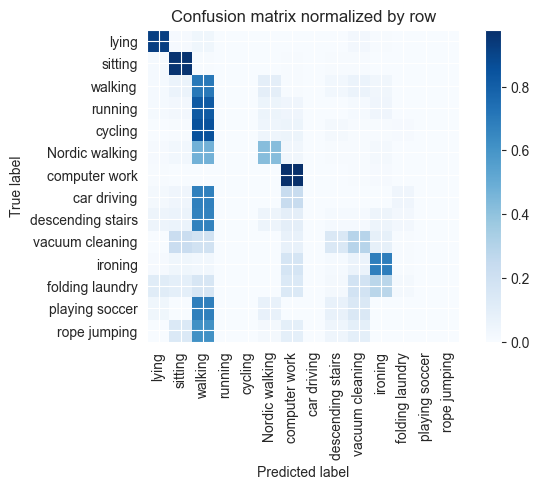

Training Epoch:  53%|█████▎    | 8/15 [1:28:26<1:28:21, 757.37s/it]

Overall accuracy: 0.531




train: 100%|██████████| 255/255 [12:46<00:00,  3.01s/batch, loss=24.2, accuracy=0.594]

seen: 100%|██████████| 63/63 [01:03<00:00,  1.01s/batch, loss=21.8]


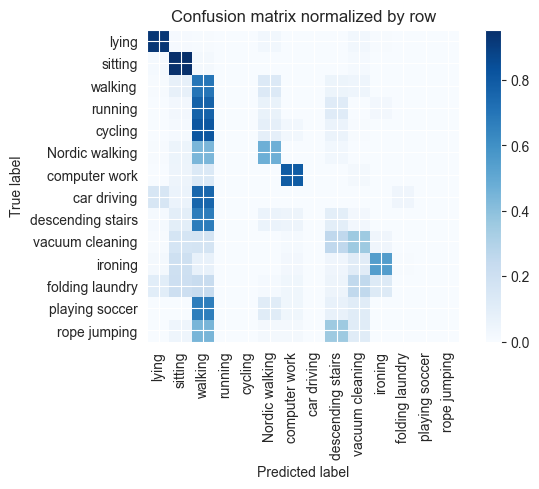

Training Epoch:  60%|██████    | 9/15 [1:42:17<1:18:02, 780.35s/it]

Overall accuracy: 0.500




train: 100%|██████████| 255/255 [13:13<00:00,  3.11s/batch, loss=16.3, accuracy=0.719]

seen: 100%|██████████| 63/63 [01:03<00:00,  1.01s/batch, loss=16.2]


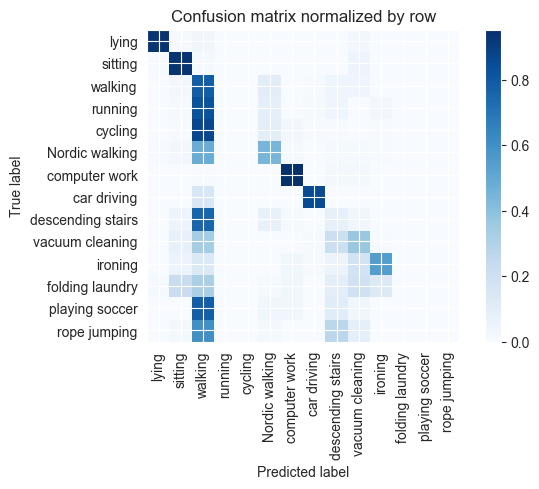

Training Epoch:  67%|██████▋   | 10/15 [1:56:35<1:07:01, 804.22s/it]

Overall accuracy: 0.551




train: 100%|██████████| 255/255 [13:24<00:00,  3.15s/batch, loss=20.2, accuracy=0.531]

seen: 100%|██████████| 63/63 [01:04<00:00,  1.02s/batch, loss=15.3]


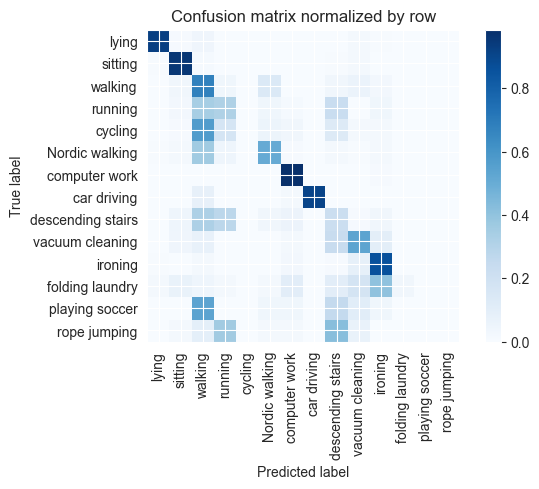

Training Epoch:  73%|███████▎  | 11/15 [2:11:04<54:55, 823.98s/it]  

Overall accuracy: 0.624




train: 100%|██████████| 255/255 [13:26<00:00,  3.16s/batch, loss=15.9, accuracy=0.625]

seen: 100%|██████████| 63/63 [01:04<00:00,  1.02s/batch, loss=14]


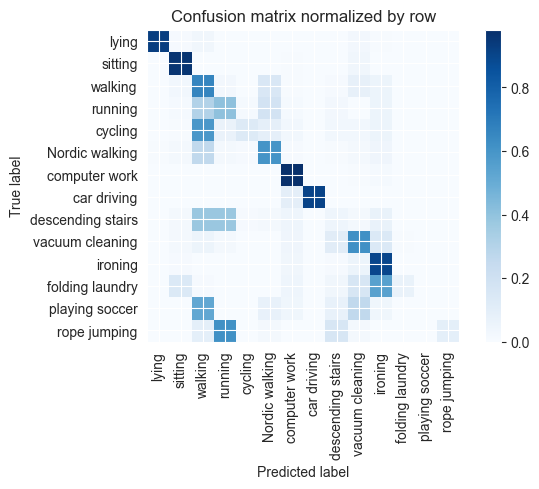

Training Epoch:  80%|████████  | 12/15 [2:25:35<41:55, 838.43s/it]

Overall accuracy: 0.653




train: 100%|██████████| 255/255 [13:19<00:00,  3.13s/batch, loss=18.2, accuracy=0.625]

seen: 100%|██████████| 63/63 [01:05<00:00,  1.04s/batch, loss=15.3]


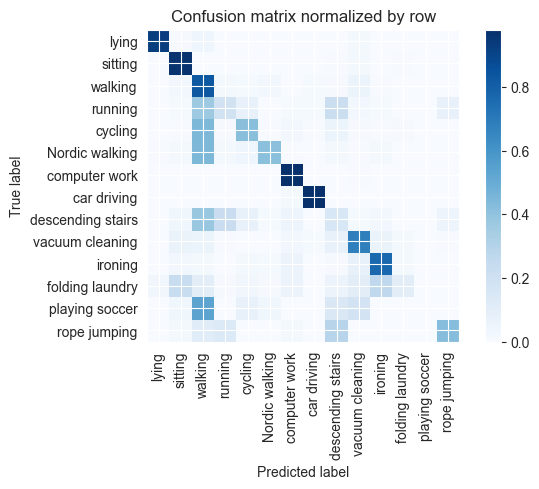

Training Epoch:  87%|████████▋ | 13/15 [2:40:01<28:13, 846.71s/it]

Overall accuracy: 0.678




train: 100%|██████████| 255/255 [13:54<00:00,  3.27s/batch, loss=15.8, accuracy=0.75]

seen: 100%|██████████| 63/63 [01:07<00:00,  1.08s/batch, loss=15.7]


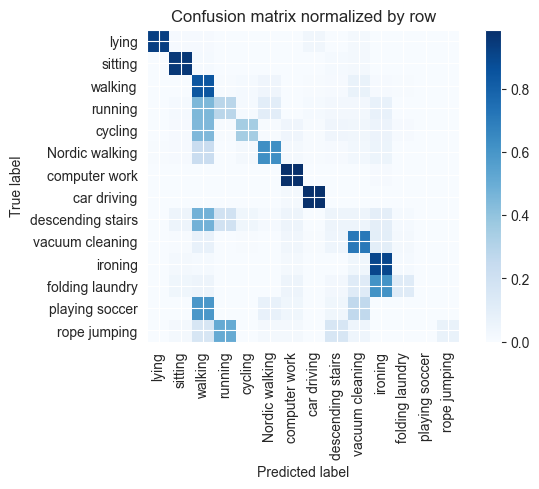

Training Epoch:  93%|█████████▎| 14/15 [2:55:04<14:23, 863.61s/it]

Overall accuracy: 0.704




train: 100%|██████████| 255/255 [13:30<00:00,  3.18s/batch, loss=20.3, accuracy=0.594]

seen: 100%|██████████| 63/63 [01:04<00:00,  1.03s/batch, loss=15.3]


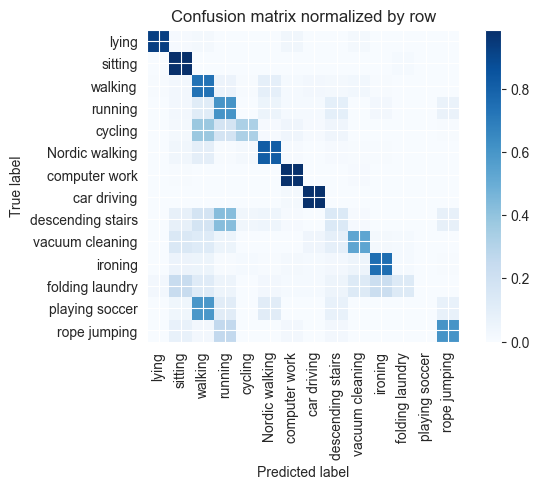

Overall accuracy: 0.703



unseen: 100%|██████████| 85/85 [01:26<00:00,  1.02s/batch, loss=48.5]


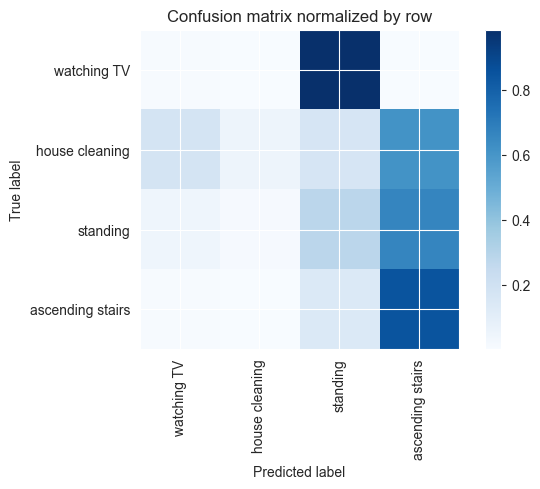

Overall accuracy: 0.265

{'accuracy': 0.2650735294117647, 'precision': 0.3297889790625588, 'recall': 0.2963577271629973, 'f1': 0.19812513176271074}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 'sitting', 'descending stairs']
Initiate IMU datasets ...


train: 100%|██████████| 256/256 [13:07<00:00,  3.08s/batch, loss=31.2, accuracy=0.188]

seen: 100%|██████████| 64/64 [01:05<00:00,  1.02s/batch, loss=32.7]


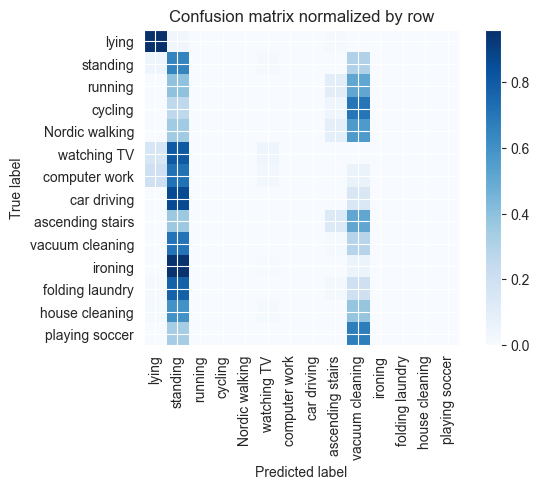

Training Epoch:   7%|▋         | 1/15 [14:13<3:19:14, 853.92s/it]

Overall accuracy: 0.175




train: 100%|██████████| 256/256 [13:40<00:00,  3.21s/batch, loss=27.7, accuracy=0.406]

seen: 100%|██████████| 64/64 [01:04<00:00,  1.01s/batch, loss=29.1]


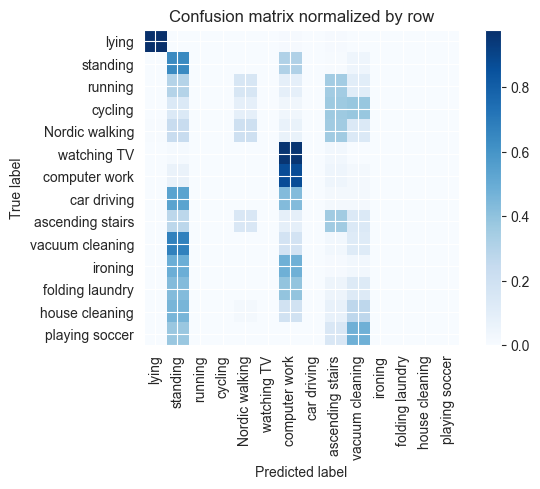

Training Epoch:  13%|█▎        | 2/15 [29:00<3:09:08, 872.95s/it]

Overall accuracy: 0.309




train: 100%|██████████| 256/256 [13:10<00:00,  3.09s/batch, loss=27.9, accuracy=0.406]

seen: 100%|██████████| 64/64 [01:04<00:00,  1.00s/batch, loss=27]


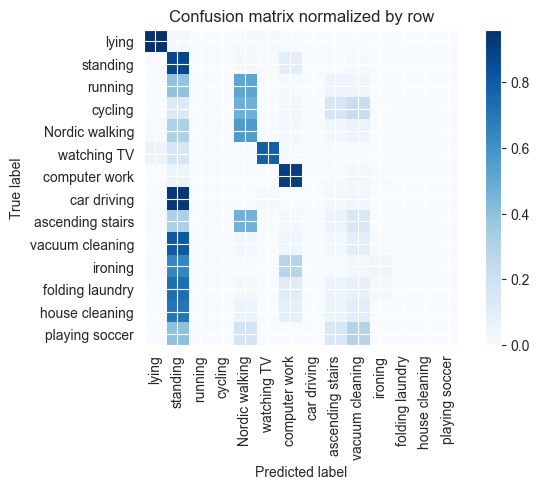

Training Epoch:  20%|██        | 3/15 [43:16<2:53:03, 865.27s/it]

Overall accuracy: 0.380




train: 100%|██████████| 256/256 [13:03<00:00,  3.06s/batch, loss=28.3, accuracy=0.438]

seen: 100%|██████████| 64/64 [01:02<00:00,  1.02batch/s, loss=29.8]


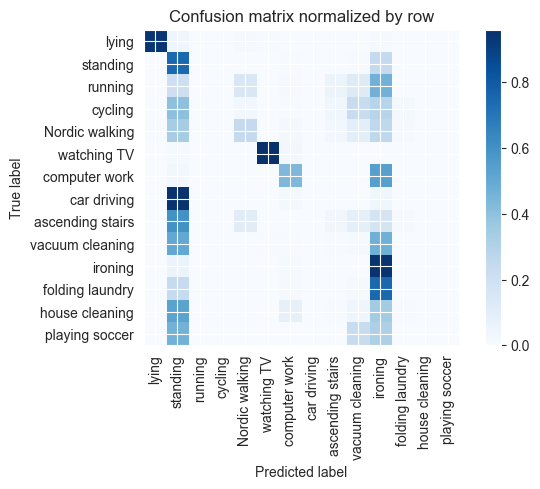

Training Epoch:  27%|██▋       | 4/15 [57:23<2:37:19, 858.13s/it]

Overall accuracy: 0.384




train: 100%|██████████| 256/256 [12:45<00:00,  2.99s/batch, loss=21.6, accuracy=0.562]

seen: 100%|██████████| 64/64 [01:05<00:00,  1.03s/batch, loss=24.3]


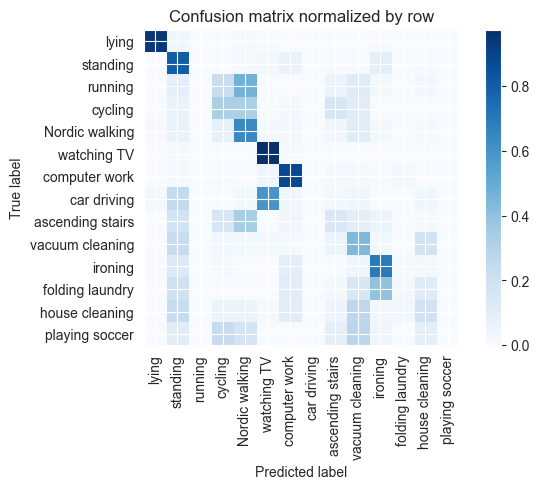

Training Epoch:  33%|███▎      | 5/15 [1:11:15<2:21:28, 848.86s/it]

Overall accuracy: 0.536




train: 100%|██████████| 256/256 [12:40<00:00,  2.97s/batch, loss=19.9, accuracy=0.594]

seen: 100%|██████████| 64/64 [01:03<00:00,  1.01batch/s, loss=22.6]


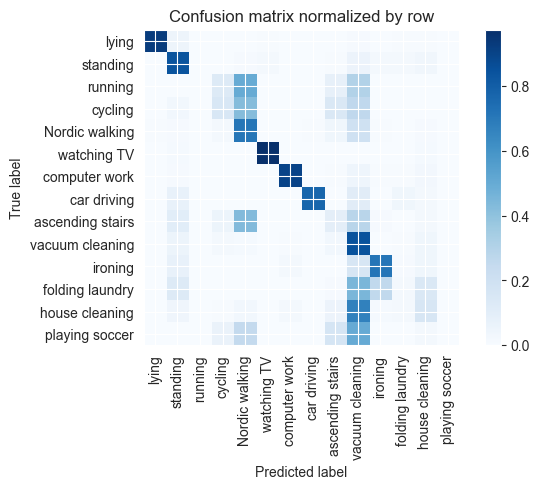

Training Epoch:  40%|████      | 6/15 [1:25:00<2:06:05, 840.65s/it]

Overall accuracy: 0.588




train: 100%|██████████| 256/256 [12:23<00:00,  2.90s/batch, loss=21.6, accuracy=0.5]

seen: 100%|██████████| 64/64 [01:03<00:00,  1.00batch/s, loss=22.9]


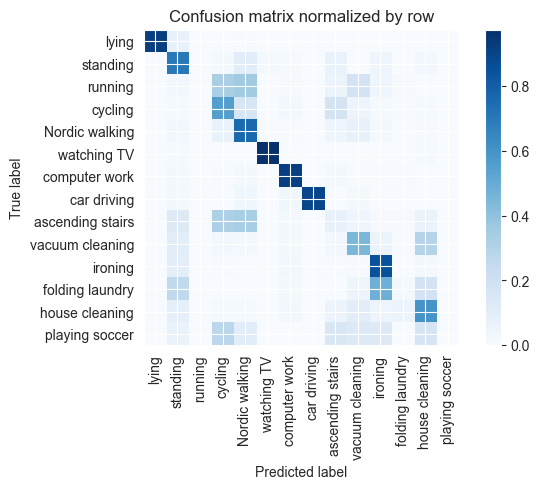

Training Epoch:  47%|████▋     | 7/15 [1:38:28<1:50:39, 829.98s/it]

Overall accuracy: 0.632




train:  23%|██▎       | 58/256 [02:51<09:46,  2.96s/batch, loss=20, accuracy=0.656]
                                                                   
KeyboardInterrupt



In [68]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):

    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=10, window_overlap=8, resample_freq=40)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat,
                             attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat,attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'],attributes=video_feat,
                             attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0
    
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=config['imu_alpha'])
        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', print_report=False, loss_alpha=config['imu_alpha'])
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes],   phase='unseen', print_report=False, loss_alpha=config['imu_alpha'])
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
